In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.tree import plot_tree
from xgboost import XGBRegressor
dfWages = pd.read_excel("AvgWages.xlsx")

# Questions to be Answered

## 1) Do women in Canada earn less than men?  
## 2) Can you predict the average wage given historical data? 

# Domain

This analysis is useful in a political contex, particularly for active feminists and employers who want to ensure equal pay. The data scopes all of the working Canadian population. 

<img src="https://upload.wikimedia.org/wikipedia/commons/9/92/Political_map_of_Canada.svg" alt="Canada" width="600"/>

# 1) Do women earn less than men?  

# Data - Relevant Columns/Rows

In [6]:
dfWages.head(1)

,Year,Geography,Type of work,Education level,Sex,Age group,Wages,Value
0,1997,Canada,Both full- and part-time,"Total, all education levels",Male,15 years and over,Total employees,5954.5


* Year - represents the year the data was taken.
* Geography - Canadian Province the participant lives in.
* Type of Work - full or part time employment.
* Education Level - education level, ranging from highschool, technical degrees, and advanced degrees.
* Sex - sex of the participant.
* Wages - type of data collected: median/average and hourly/weekly wage. (we will be focusing on average hourly wages)

**Notes:** We're interested primarly in hourly wages, because weekly and total wages are based on hourly. We're also going to look at average hourly wage instead of median.

In [8]:
## Only look at the rows with average hourly wage rate
dfHourly = dfWages[dfWages['Wages']== 'Average hourly wage rate']

## Another dataframe without the unmeployment rows
dfHourlyNU = dfHourly.loc[dfHourly['Value'] != 0]

### Wage is dependent on education level and year

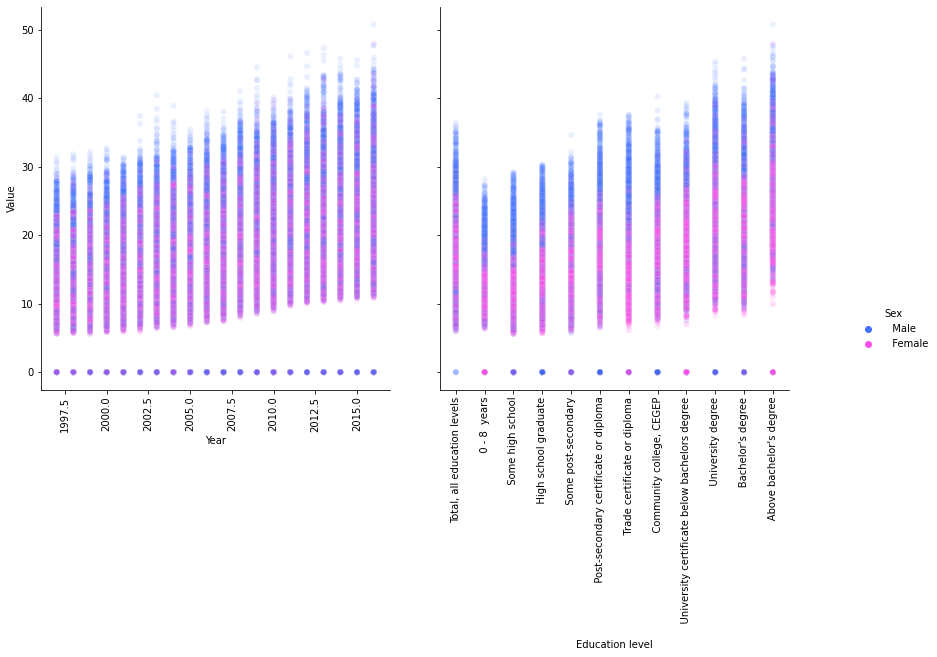

In [9]:
# Pairplot to display the relation of Year, Type of work, Education level, and Age to the avg. hourly wage.
grid = sns.pairplot(
    data=dfHourly,
    hue="Sex",
    palette=sns.color_palette(["#4271ff", "#ff4fea"]),
    x_vars=["Year", "Education level"],
    y_vars=["Value"],
    diag_kind = None,
    height=6,
    plot_kws={'alpha':0.1},
)

# Rotate x-axis on each plot so they are readable
for ax in grid.axes.flat[:]:
    ax.tick_params(axis='x', labelrotation=90)

**Notes:** Wages have increased steadily overall from 1997 to 2016. Some levels of education seem to have a larger difference between male and female pay. Particularly, the "Trade certificate or diploma" education category has nearly total separation between male and female pay.

### Alberta and Oil

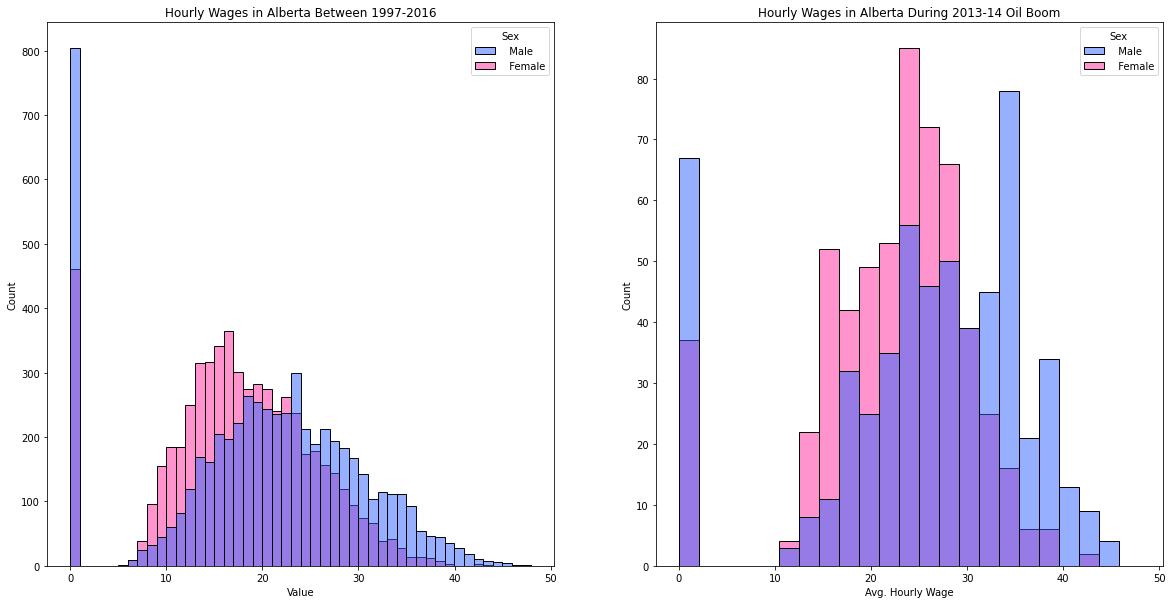

In [10]:
# Observe wage trends during the Alberta oil boom of 2013-14

# Wages durin 2013-14 boom
dfAlbertaOilBoom = dfHourly.loc[(dfHourly["Geography"] == "Alberta") & ((dfHourly["Year"] == 2013) | (dfHourly["Year"] == 2014))]

# Wage trends over all observed time in Alberta
dfAlberta = dfHourly.loc[(dfHourly["Geography"] == "Alberta")]


# Two subplots
fig, (ax1, ax2) = plt.subplots(1,2,  figsize=(20, 10), sharex=True)
colors = sns.color_palette(["#2e62ff", "#ff299f"])

sns.histplot(x="Value", hue="Sex", data=dfAlberta, palette=colors, ax=ax1)
ax1.set_title("Hourly Wages in Alberta Between 1997-2016")
sns.histplot(x="Value", hue="Sex", data=dfAlbertaOilBoom, palette=colors, ax=ax2)
ax2.set_title("Hourly Wages in Alberta During 2013-14 Oil Boom")
ax2.set_xlabel('Avg. Hourly Wage')
plt.show()

**Notes:** There is a large unemployment drop during the boom. During the boom, men have a slightly higher average hourly wage compared to women. Compared to the overall Albertan wages, the wage gap notably decreases during the oil boom. On the oil boom plot, the outlying large bin of male wages (around $35) could indicate the hourly pay given to newly-hired oil rig workers. 

### Hourly wage difference and unemployment over the years

In [11]:
#Get the hourly wages from female and male 
dfHourly_female = dfHourly[dfHourly['Sex'] == '  Female']
dfHourly_male = dfHourly[dfHourly['Sex'] == '  Male']

#Get hourly wages from female and male without unmeployment
dfHourlyNU_female = dfHourlyNU[dfHourlyNU['Sex'] == '  Female']
dfHourlyNU_male = dfHourlyNU[dfHourlyNU['Sex'] == '  Male']

In [12]:
# Go through the years and observe the difference 
years = list(set(np.sort(dfHourlyNU_female['Year'].values)))
male_means, female_means= [], []
difference_1 = []

# Iterate through the years and find the mean and their differences
for year in years: 
    
    # Find the mean for each 
    femaleMean_yearly = dfHourlyNU_female[dfHourlyNU_female['Year'] == year]['Value'].mean()
    maleMean_yearly = dfHourlyNU_male[dfHourlyNU_male['Year'] == year]['Value'].mean()
    diff = maleMean_yearly - femaleMean_yearly
    
    # Append the mean for each 
    female_means.append(femaleMean_yearly)
    male_means.append(maleMean_yearly)
    difference_1.append(diff)
    
# Select only unemployed persons
dfUnemployed_male = dfHourly_male[dfHourly_male["Value"] == 0]
dfUnemployed_female = dfHourly_female[dfHourly_female["Value"] == 0]

years = list(range(1997,2017))
male_unemply = []
fem_unemply = []
difference = []    
for year in years: 

    # Find the mean for each 
    male_unemployed = dfUnemployed_male[dfUnemployed_male['Year'] == year].shape[0]
    female_unemployed = dfUnemployed_female[dfUnemployed_female['Year'] == year].shape[0]
    
    diff = male_unemployed - female_unemployed
    
    # Look at the diferences
    male_unemply.append(male_unemployed)
    fem_unemply.append(female_unemployed)
    difference.append(diff)

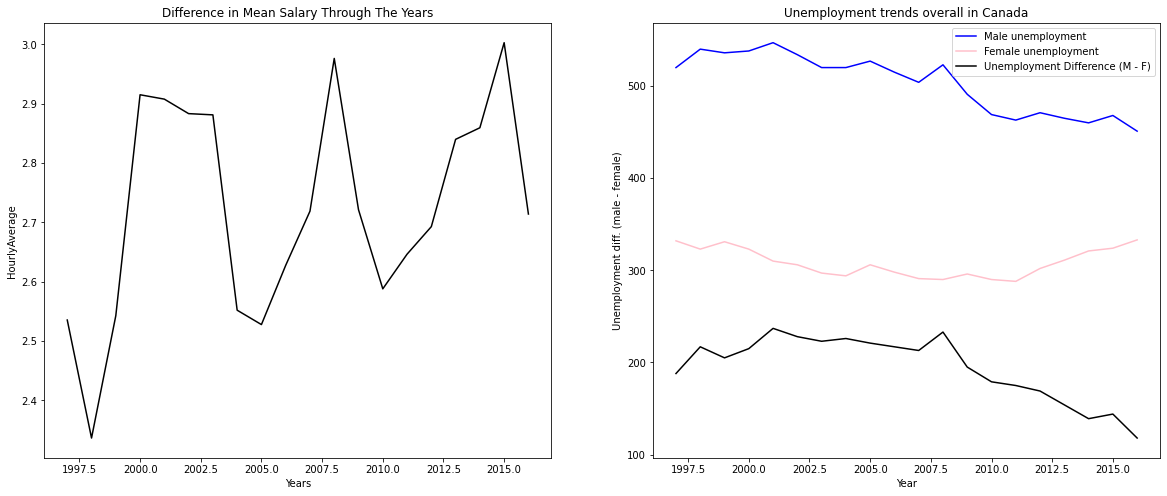

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2,  figsize=(20, 8), sharex=True)


ax1.plot(years, difference_1, color = 'black', label = 'difference')
ax1.title.set_text("Difference in Mean Salary Through The Years")
ax1.set_xlabel('Years')
ax1.set_ylabel('HourlyAverage')

# plot the data
ax2.plot(years, male_unemply, label="Male unemployment", c="blue")
ax2.plot(years, fem_unemply, label="Female unemployment", c="pink")
ax2.plot(years, difference, label="Unemployment Difference (M - F)", c="black")
ax2.set_xlabel("Year")
ax2.set_ylabel("Unemployment diff. (male - female)")
ax2.title.set_text("Unemployment trends overall in Canada")
ax2.legend(loc = 'upper right')

plt.show()

We notice that the peak years for hourlyWage difference between males and females are in the 2000, 2008, and 2014. This is interesting to note because those are years where recessions happened. In 2000, there was the .com bubble. In 2008, there was the housing market collapse, and in 2014, there were the reduction of oil prices. It is important to note this to further investiage why there is a bigger pay gap during recessions. 

**Notes:**  Holistically, males tend to have higher unemployment rates than women. 

**Economic recession.**
Around the years 2000 to 2001, during a mild recession, the difference in unemplyoment dips, with men losing their jobs at an increased rate compared to women. With this 2000-2001 recession, female unemployment slightly decreases and male unemployment slightly increases. From 2008-2009, a major recession occured, with more men becoming unemployed compared to women. Mid-2015 was also a period of minor recession, with relatively little impact on unemployment due to the recession being short. Recession tends to increase male unemployment without affecting female unemployment.

**Economic growth.**
Outside of these recession periods, during economic growth, the unemployment gap often shrinks. For example, directly following the early 2000s recession, there is a slow decrease in the unemployment gap between men and women. This likely indicates men who lost their jobs are returning to the workforce following recession periods. Around the more recent years of 2015-16, the unemployment gap is very small, with female unemployment increasing.

**Notes:** This is the plot of every province's unemployment difference (Male - Female) over time.

**Alberta, 2003.** Growth in the oil sector led to great increases in male employment, while female employment was not similarly affected. However, this effect does not last due to decreasing oil prices.

**Ontario & Quebec.** These two provinces are some of the most urban and populous in Canada. It seems that more urban, "knowledge economy"/tech-oritented provinces have a lower unemployment gap.

# 2) Can you predict the average wage given historical data? 

### Preprocessing

In [52]:
data = pd.read_csv("AvgWages.csv")
dataHourlyEmp = data[data['Wages'] == 'Average hourly wage rate']
dataHourlyEmp.head()

,Year,Geography,Type of work,Education level,Sex,Age group,Wages,Value
3840,1997,Canada,Both full- and part-time,"Total, all education levels",Male,15 years and over,Average hourly wage rate,17.09
3841,1998,Canada,Both full- and part-time,"Total, all education levels",Male,15 years and over,Average hourly wage rate,17.33
3842,1999,Canada,Both full- and part-time,"Total, all education levels",Male,15 years and over,Average hourly wage rate,17.80
3843,2000,Canada,Both full- and part-time,"Total, all education levels",Male,15 years and over,Average hourly wage rate,18.38
3844,2001,Canada,Both full- and part-time,"Total, all education levels",Male,15 years and over,Average hourly wage rate,18.98


In [53]:
dataHourlyEmp = dataHourlyEmp[dataHourlyEmp['Value'] != 0]
dataHourlyUnEmp = dataHourlyEmp[dataHourlyEmp['Value'] == 0]
dataHourlyEmp.head(10)
# Randomnize the data First
dataHourlyEmp = dataHourlyEmp.sample(frac=1).reset_index(drop=True)
dataHourlyEmp['Value'].mean()
# Split into X and y
y = dataHourlyEmp['Value']
X = dataHourlyEmp.drop(columns = ['Value', 'Wages']).apply(LabelEncoder().fit_transform)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 1)
X.head()

,Year,Geography,Type of work,Education level,Sex,Age group
0,18,0,2,2,0,5
1,9,3,0,9,0,4
2,3,7,1,5,1,6
3,10,5,1,11,0,4
4,8,2,0,10,0,2


## Expected Objective

Given the dataset column categories as input, we expect to be able to predict the wage of a person.

* Features(inputs): Year, Geography, Type of work, Education level, Sex, Age group
* Target(output): Value (average hourly wage, Canadian dollars)

### Training - Overview of all models tried

| Regression Model  | MAE    |
|-------------------|--------|
| Decision tree     | 0.8853 |
| Random Forest     | 0.7278 |
| XGBoost (untuned) | 0.6708 |
| XGBoost (tuned)   | 0.5170 |

In [47]:
# Define
model_DT = DecisionTreeRegressor()

# Fit
model_DT.fit(X_train, y_train)

# Predict
y_test_pred = model_DT.predict(X_test)

# Evaluate 
mae = mean_absolute_error(y_test, y_test_pred)

print('MAE (after train-test-split):')
print(mae)

MAE (after train-test-split):
0.8933920086881759


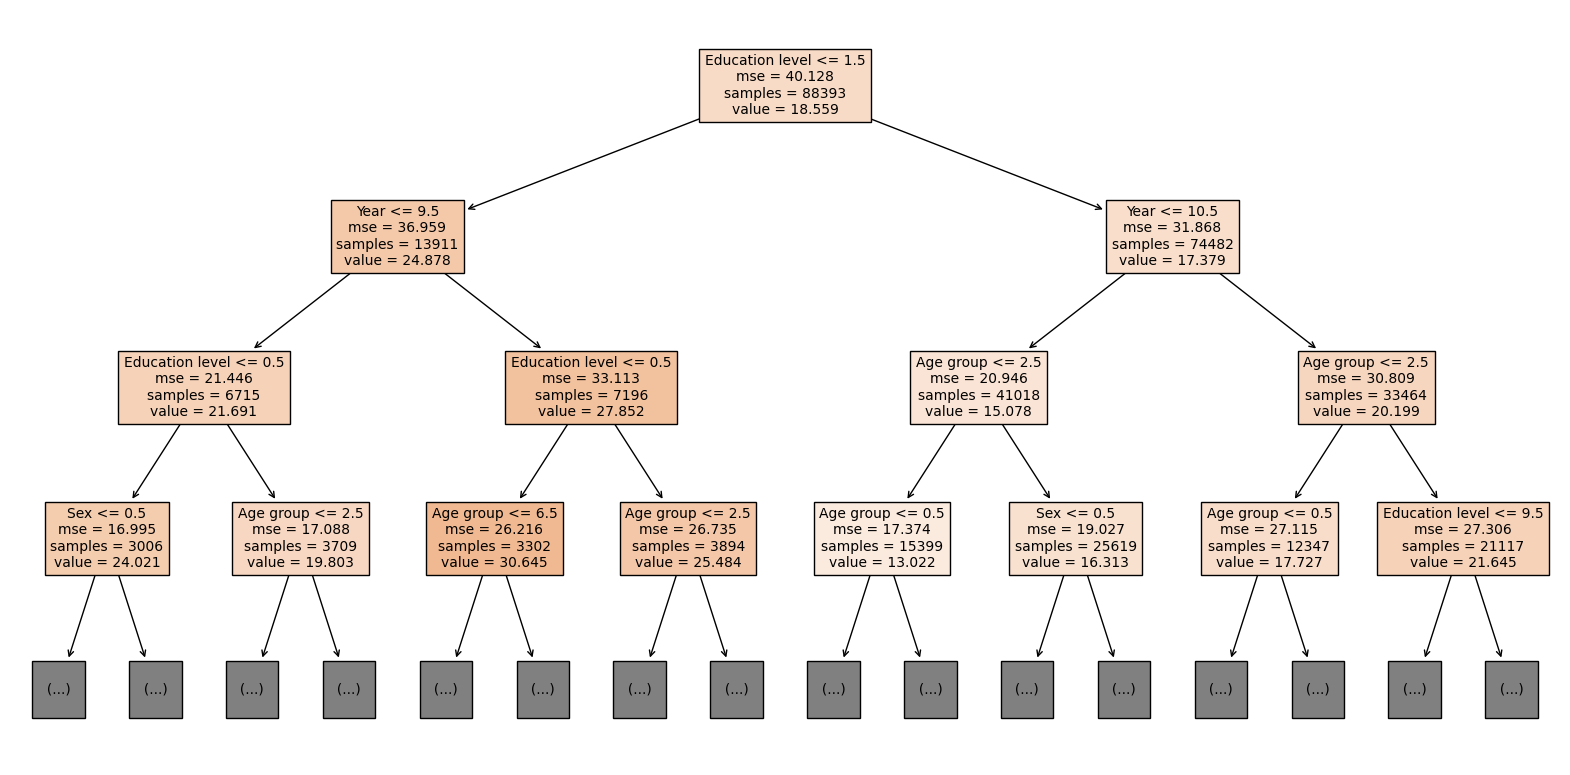

In [48]:
plt.figure(figsize=(20,10), dpi=100)
plot_tree(model_DT, max_depth=3, feature_names=X.columns, fontsize=10, filled=True)
plt.show()

Given the dataset column categories as input, we expect to be able to predict the wage of a person.

* Inputs: Year, Geography, Type of work, Education level, Sex, Age group
* Outputs: Value (average hourly wage, Canadian dollars)

### Training - Evaluation metric of best model

We will be using Mean Absolute Error to evaluate our models. MAE represents the average magnitude of error, and it ignores whether the error is in the positive or negative direction. A higher MAE means the predictions generally have lots of error from the actual values, so we choose the model with the lowest MAE, the tuned XGBoost model.

### Training - Tuning the Boosted Tree

**Note:** A max depth of 14 gives us the lowest MAE, so we use this parameter in our model.

**Note:** Using different n_estimators does not greatly affect the model, so we do not use this parameter.

# Scoring 

### Scoring - run model real-time

**Final model - Boosted tree**

In [54]:
%%time
# Load data
import pandas as pd
data = pd.read_csv("AvgWages.csv")
dataHourlyEmp = data[data['Wages'] == 'Average hourly wage rate']
dataHourlyEmp = dataHourlyEmp[dataHourlyEmp['Value'] != 0]

print("Avg. of hourly wages:", round(dataHourlyEmp['Value'].mean(), 4))
print()

# Split into X and y
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

y = dataHourlyEmp['Value']
X = dataHourlyEmp.drop(columns = ['Value', 'Wages']).apply(LabelEncoder().fit_transform)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 1)

# Define model
from xgboost import XGBRegressor
model_XG = XGBRegressor(max_depth = 14)

# Fit model
model_XG.fit(X_train, y_train)

# Predict
y_test_pred = model_XG.predict(X_test)

# Evaluate with MAE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_test_pred)
print('MAE from default XGBoost model: ', round(mae, 4))

print()

Avg. of hourly wages: 18.5674

MAE from default XGBoost model:  0.517

Wall time: 25.2 s


In [62]:
plt.figure(figsize  = (20, 10))
X_prediction = X_test.copy()
X_prediction['True'] = y_test
X_prediction['Prediction'] = y_test_pred
X_prediction = X_prediction.reset_index().drop(columns = ['index'])
X_prediction.head(10)

,Year,Geography,Type of work,Education level,Sex,Age group,True,Prediction
0,9,5,2,9,0,1,8.55,8.502405
1,18,0,2,10,0,5,33.36,33.039822
2,5,3,2,11,0,5,15.73,15.862868
3,12,6,2,8,0,2,10.08,10.955655
4,0,7,1,3,0,7,11.13,11.308805
5,17,3,1,10,1,5,19.80,22.554382
6,14,0,1,11,1,5,20.84,20.882153
7,3,3,1,8,0,2,8.57,8.292239
8,18,5,2,0,1,7,41.25,37.504356
9,6,5,1,5,0,3,7.41,7.654622


<Figure size 1440x720 with 0 Axes>

### Scoring - sample input

#### Need to extract encoded feature numbers from label enconding

In [88]:
from collections import defaultdict
d = defaultdict(LabelEncoder)

# Encoding the variable
fit = X.apply(lambda x: d[x.name].fit_transform(x))

# Inverse the encoded
fit.apply(lambda x: d[x.name].inverse_transform(x))

# Using the dictionary to label future data
X.apply(lambda x: d[x.name].transform(x))

print(d)
d['Geography'].inverse_transform(X['Geography'])

defaultdict(<class 'sklearn.preprocessing._label.LabelEncoder'>, {'Year': LabelEncoder(), 'Geography': LabelEncoder(), 'Type of work': LabelEncoder(), 'Education level': LabelEncoder(), 'Sex': LabelEncoder(), 'Age group': LabelEncoder()})


array([2, 2, 2, ..., 1, 1, 1])

In [89]:
geography = defaultdict(int)
encoded = d['Geography'].inverse_transform(X['Geography'])
counter = 0
for value in dataHourlyEmp['Geography']:

    geography[value] = encoded[counter]
    counter += 1
    
#print(geography)

typeOfWork = defaultdict(int)
encoded = d['Type of work'].inverse_transform(X['Type of work'])
counter = 0
for value in dataHourlyEmp['Type of work']:

    typeOfWork[value] = encoded[counter]
    counter += 1
    
#print(typeOfWork)

education = defaultdict(int)
encoded = d['Education level'].inverse_transform(X['Education level'])
counter = 0
for value in dataHourlyEmp['Education level']:

    education[value] = encoded[counter]
    counter += 1
    
#print(education)

sex = defaultdict(int)
encoded = d['Sex'].inverse_transform(X['Sex'])
counter = 0
for value in dataHourlyEmp['Sex']:

    sex[value] = encoded[counter]
    counter += 1
    
#print(sex)

age = defaultdict(int)
encoded = d['Age group'].inverse_transform(X['Age group'])
counter = 0
for value in dataHourlyEmp['Age group']:

    age[value] = encoded[counter]
    counter += 1
    
#print(age)


In [91]:
print(age)
print(geography)
print(education)
print(sex)

defaultdict(<class 'int'>, {'15 years and over ': 0, '15-24 years': 1, '20-34 years': 2, '25 years and over': 3, '25-34 years': 4, '25-54 years': 5, '25-64 years': 6, '55 years and over': 7})
defaultdict(<class 'int'>, {'Canada': 2, 'Newfoundland and Labrador': 5, 'Prince Edward Island': 8, 'Nova Scotia': 6, 'New Brunswick': 4, 'Quebec': 9, 'Ontario': 7, 'Manitoba': 3, 'Saskatchewan': 10, 'Alberta': 0, 'British Columbia': 1})
defaultdict(<class 'int'>, {'Total, all education levels': 11, '   0 - 8  years': 5, '   Some high school': 8, '   High school graduate': 6, '   Some post-secondary': 9, '   Post-secondary certificate or diploma': 7, '    Trade certificate or diploma': 3, '    Community college, CEGEP': 2, '    University certificate below bachelors degree': 4, '   University degree': 10, "      Bachelor's degree": 1, "      Above bachelor's degree": 0})
defaultdict(<class 'int'>, {'  Male': 1, '  Female': 0})


#### Sample Input -> Sample Output

In [93]:
from pandas import DataFrame

# Create sample input row
sample_input = [[geography['Alberta'], typeOfWork['Full-time'], education['   Some high school'], sex['  Male'], age['20-34 years'], 2007]]
sample = ['Alberta', 'Full-time', 'Above bachelors degree', 'Male', '15 years and over', 2007]

#convert to correct format
dfSample = DataFrame (sample_input,columns=['Year', 'Geography','Type of work', 'Education level', 'Sex', 'Age group'])


# Predict using model
sample_output = model_XG.predict(dfSample)

print('A person with the characteristics of:', sample, 'will have a wage of: ', sample_output)

# Create sample input row
sample_input = [[geography['Alberta'], typeOfWork['Full-time'], education['   Some high school'], sex['  Female'], age['20-34 years'], 2007]]
sample = ['Alberta', 'Full-time', 'Above bachelors degree', 'Female', '15 years and over', 2007]

#convert to correct format
dfSample = DataFrame (sample_input,columns=['Year', 'Geography','Type of work', 'Education level', 'Sex', 'Age group'])


# Predict using model
sample_output = model_XG.predict(dfSample)

print('A person with the characteristics of:', sample, 'will have a wage of: ', sample_output)

A person with the characteristics of: ['Alberta', 'Full-time', 'Above bachelors degree', 'Male', '15 years and over', 2007] will have a wage of:  [26.269464]
A person with the characteristics of: ['Alberta', 'Full-time', 'Above bachelors degree', 'Female', '15 years and over', 2007] will have a wage of:  [26.670351]


# Takeaways from the model

Our model predicts the wage of someone given that they are employed and given their province, type of work, education level, sex, age group, and the year.

However, our model does not check whether the person may be unemployed. The unemployment data (where the wage is zero) has been ignored when creating the model. It may be appropriate to create a separate model, which predicts unemployment, and use that model to first check whether the input person may be unemployed.